# Lesson 5 - Random forest deep dive

> A deep dive into how Random Forests work and some tricks for making them more accurate.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/dslectures/master?urlpath=lab/tree/notebooks%2Flesson05_random-forest-deep-dive.ipynb) 
[![slides](https://img.shields.io/static/v1?label=slides&message=lesson05_random-forest-deep-dive.pdf&color=blue&logo=Google-drive)](https://drive.google.com/open?id=1xRpRXFY_wMzHn2QgW3nDzULh8Y7G5IVt)

## Learning objectives

* Understand how to go from simple to complex models
* Understand the concepts of bagging and out-of-bag score
* Gain an introduction to hyperparameter tuning

## References

This lesson is adapted from Jeremy Howard's fantastic online course [_Introduction to Machine Learning for Coders_](https://course18.fast.ai/ml), in particular:

* [2 - Random Forest Deep Dive](https://course18.fast.ai/lessonsml1/lesson2.html)

## Homework

* Solve the exercises included in this notebook
* Read chapter 7 of _Hands-On Machine Learning with Scikit-Learn and TensorFlow_ by Aurèlien Geron

## The data

In this lesson we will analyse the preprocessed table of clean housing data and their addresses that we prepared in lesson 3:

* `housing_processed.csv`

## How does a random forest work for regression tasks?

<div style="text-align: center">
<img src='images/rf-regression.png' width='700'>
</div>

When we use a Random Forest to solve a regression task, the basic idea is that the _leaf nodes_ of each Decision Tree predict a numerical value that is the average of the training instances associated with that node. These predictions are then _averaged_ to obtain the final prediction from the forest of trees. In this lesson we will look at how we can build predictions from a single tree and get better predictions by adding progressively more trees to the forest.

## Import libraries

In [1]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

In [2]:
# uncomment to update the library if working locally
# !pip install dslectures --upgrade

In [3]:
# data wrangling
import pandas as pd
import numpy as np
from numpy.testing import assert_array_equal
from dslectures.core import *
from dslectures.structured import *
from pathlib import Path
import pickle

# data viz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

# ml magic
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

## Load the data

In [4]:
get_dataset('housing_processed.csv')

Download of housing_processed.csv dataset complete.


We also make use of the `pathlib` library to handle our filepaths:

In [5]:
DATA = Path('../data/')
!ls {DATA}

housing_processed.csv


In [6]:
housing_data = pd.read_csv(DATA/'housing_processed.csv'); housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,city,postal_code,rooms_per_household,bedrooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_<1H OCEAN,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_ISLAND
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,69,94705,6.984127,1.023810,0.146591,2.555556,0,0,1,0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,620,94611,6.238137,0.971880,0.155797,2.109842,0,0,1,0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,620,94618,8.288136,1.073446,0.129516,2.802260,0,0,1,0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,620,94618,5.817352,1.073059,0.184458,2.547945,0,0,1,0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,620,94618,6.281853,1.081081,0.172096,2.181467,0,0,1,0,0


With the data loaded, we can recreate our feature matrix $X$ and target vector $y$ and train/validation splits as before.

---

#### Exercise #1

* Create the feature matrix $X$ and target vector $y$ from `housing_data`
* Create training and validation sets with a split of 80:20

---

In [7]:
X = housing_data.drop("median_house_value", axis=1)
y = housing_data["median_house_value"]

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'{len(X_train)} train rows + {len(X_valid)} valid rows')

15554 train rows + 3889 valid rows


## Baseline model

As a sanity check, let's see how our baseline model performs on the validation set:

In [9]:
model = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)

In [10]:
model.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

To simplify the evaluation of our models, let's write a simple function to keep track of the scores:

In [11]:
def print_rf_scores(fitted_model):
    """Generates RMSE and R^2 scores from fitted Random Forest model."""

    yhat_train = fitted_model.predict(X_train)
    R2_train = fitted_model.score(X_train, y_train)
    yhat_valid = fitted_model.predict(X_valid)
    R2_valid = fitted_model.score(X_valid, y_valid)

    scores = {
        "RMSE on train:": rmse(y_train, yhat_train),
        "R^2 on train:": R2_train,
        "RMSE on valid:": rmse(y_valid, yhat_valid),
        "R^2 on valid:": R2_valid,
    }
    if hasattr(fitted_model, "oob_score_"):
        scores["OOB R^2:"] = fitted_model.oob_score_

    for score_name, score_value in scores.items():
        print(score_name, round(score_value, 3))

In [12]:
print_rf_scores(model)

RMSE on train: 19142.338
R^2 on train: 0.961
RMSE on valid: 19360.06
R^2 on valid: 0.961


## The simplest model: a single tree

Let's build a model that is so simple that we can actually take a look at it. As we saw in lesson 4, a Random Forest is a simply forest of decision trees, so let's begin by looking at a single tree (called _estimators_ in scikit-learn): 

In [13]:
model = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In the above we have fixed the following hyperparameters:

* `n_estimators = 1`: create a forest with one tree, i.e. a _decision tree_
* `max_depth = 3`: how deep or the number of "levels" in the tree
* `bootstrap=False`: this setting ensures we use the whole dataset to build the tree

Let's see how this simple model performs:

In [14]:
print_rf_scores(model)

RMSE on train: 65040.247
R^2 on train: 0.545
RMSE on valid: 67579.11
R^2 on valid: 0.525


Unsurprisingly, this single tree yields worse predictions ($R^2 = 0.53$) than our baseline with 10 trees ($R^2 = 0.96$). Nevertheless, we can visualise the tree by accessing the `estimators_` attribute and making use of scikit-learn's plotting API ([link](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)):

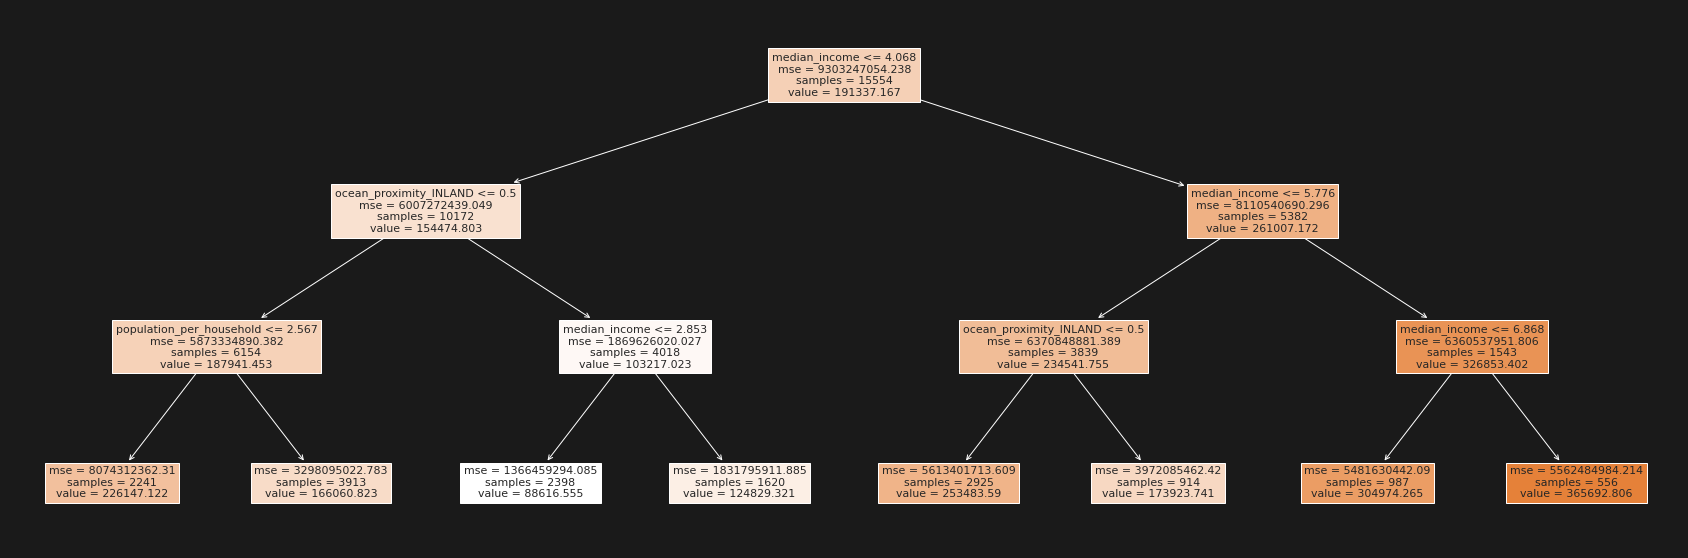

In [15]:
# get column names
feature_names = X_train.columns
# we need to specify the background color because of a bug in sklearn
fig, ax = plt.subplots(figsize=(30,10), facecolor='k')
# generate tree plot
plot_tree(model.estimators_[0], filled=True, feature_names=feature_names, ax=ax)
plt.show()

From the figure we observe that a tree consists of a sequence of binary decisions, where each box includes information about:

* The binary split criterion (mean squared error (mse) in this case)
* The number of `samples` in each node. Note we start with the full dataset in the root node and get successively smaller values at each split.
* Darker colours indicate a higher `value`, where `value` refers to the _average_ of of the prices. 
* The best single binary split is for `median_income <= 4.068` which improves the mean squared error from 9.3 billion to 6.0 billion.

## A slightly better model

Right now our simple tree model has $R^2 = 0.53$ on the validation set - let's make it better by removing the `max_depth=3` restriction:

In [16]:
model = RandomForestRegressor(n_estimators=10, bootstrap=False, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [17]:
print_rf_scores(model)

RMSE on train: 0.0
R^2 on train: 1.0
RMSE on valid: 58570.323
R^2 on valid: 0.643


Note that removing the `max_depth` constraint has yielded a _perfect_ $R^2=1$ on the training set! That is because in this case each leaf node has exactly one element, so we can perfectly segment the data. We also have $R^2 = 0.64$ on the validation set which is better than our shallow tree, but we can do better.

## Introduction to bagging

Bagging is a technique that can be used to improve the ability of models to generalise to new data.

The basic idea between bagging is to consider training _several_ models, each of which is only partially predictive, but crucially, uncorrelated. Since these models are effectively gaining different insights into the data, by averaging their predictions we can create an _ensemble_ that is more predictive!

As shown in the figure, bagging is a two-step process:

1. Bootstrapping, i.e. sampling the training set
2. Aggregation, i.e. averaging predictions from multiple models

This gives us the acronym Bootstrap AGGregatING, or bagging for short 🤓.

The key for this to work is to ensure the errors of each mode are uncorrelated, so the way we do that with trees is to _**sample with replacement**_ from the data: this produces a set of independent samples upon which we can train our models for the ensemble.
<div style="text-align: center">
<img src='images/bagging.png' width='700'>
<p style="text-align: center;"> <b>Figure reference:</b> https://bit.ly/33tGPVT </p>
</div>

## Hyperparameter tuning

If we revisit our very first model, we saw that the number of trees (`n_estimators`) is one of the parameters we can tune when building our Random Forest. Let's look at this more closely and see how the performance of the forest improves as we add trees.

In [18]:
model = RandomForestRegressor(n_estimators=10, bootstrap=True, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

After training, each tree is stored in an attribute called `estimators_`. For each tree, we can call `predict()` on the validation set and use the `numpy.stack()` function to concatenate the predictions together:

In [19]:
preds = np.stack([tree.predict(X_valid) for tree in model.estimators_])

Since we have 10 trees and 3889 samples in our validation set, we expect that `preds` will have shape $(n_\mathrm{trees}, n_\mathrm{samples})$:

In [20]:
preds.shape

(10, 3889)

**Note:** To calculate `preds` we made use of Python's list comprehension. An alternative way to do this would be to use a for-loop as follows:

In [21]:
preds_list = []

for tree in model.estimators_:
    preds_list.append(tree.predict(X_valid))

# concatenate list of predictions into single array 
preds_v2 = np.stack(preds_list)

# test that arrays are equal
assert_array_equal(preds, preds_v2)

Let's now look at a plot of the $R^2$ values as we increase the number of trees.

In [22]:
def plot_r2_vs_trees(preds, y_valid):
    """Generate a plot of R^2 score on validation set vs number of trees in Random Forest"""
    fig, ax = plt.subplots()
    plt.plot(
        [
            r2_score(y_valid, np.mean(preds[: i + 1], axis=0))
            for i in range(len(preds) + 1)
        ]
    )
    ax.set_ylabel("$R^2$ on validation set")
    ax.set_xlabel("Number of trees")

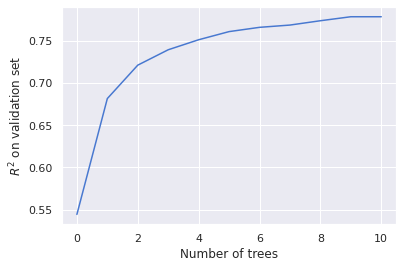

In [23]:
plot_r2_vs_trees(preds, y_valid)

As we add more trees, $R^2$ improves but appears to flatten out. Let's test this numerically.

---

#### Exercise #2

* Increase the number of trees in the forest by changing `n_estimators` from 10 to 20, 40, and 80 and print their metrics.
* For the forest with 80 tree, generate the array of predictions for each tree and plot the $R^2$ value against the number of trees.

---

#### Solution #2 mla

In [24]:
model_20t = RandomForestRegressor(n_estimators=20, bootstrap=True, n_jobs=-1, random_state=42)
model_20t.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [25]:
preds_20t = np.stack([tree.predict(X_valid) for tree in model_20t.estimators_])

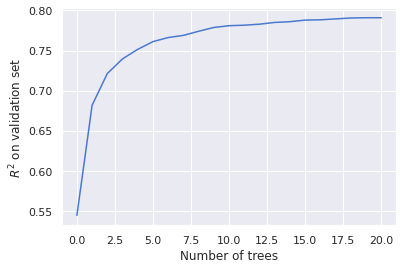

In [26]:
plot_r2_vs_trees(preds_20t, y_valid)

In [27]:
model_40t = RandomForestRegressor(n_estimators=40, bootstrap=True, n_jobs=-1, random_state=42)
model_40t.fit(X_train, y_train)

preds_40t = np.stack([tree.predict(X_valid) for tree in model_40t.estimators_])

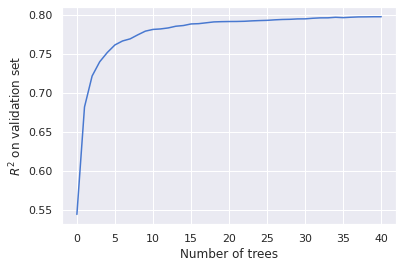

In [28]:
plot_r2_vs_trees(preds_40t, y_valid)

In [29]:
model_80t = RandomForestRegressor(n_estimators=80, bootstrap=True, n_jobs=-1, random_state=42)
model_80t.fit(X_train, y_train)

preds_80t = np.stack([tree.predict(X_valid) for tree in model_80t.estimators_])

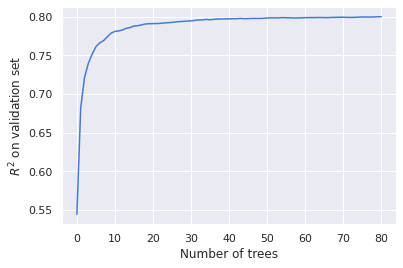

In [30]:
plot_r2_vs_trees(preds_80t, y_valid)

In [31]:
model_160t = RandomForestRegressor(n_estimators=160, bootstrap=True, n_jobs=-1, random_state=42)
model_160t.fit(X_train, y_train)

preds_160t = np.stack([tree.predict(X_valid) for tree in model_160t.estimators_])

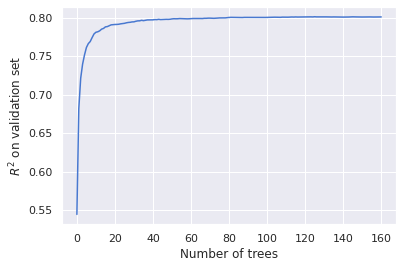

In [32]:
plot_r2_vs_trees(preds_160t, y_valid)

## Out-Of-Bag (OOB) score

So far, we've been using a validation set to examine the effect of tuning hyperparameters like the number of trees - what happens if the dataset is small and it may not be feasible to create a validation set because you would not have enough data to build a good model? Random Forests have a nice feature called _**Out-Of-Bag (OOB) error**_ which is designed for just this case!

The key idea is to observe that the first tree of our ensemble was trained on a bagged sample of the full dataset, so if we evaluate this model on the _remaining_ samples we have effectively created a _validation set per tree._ To generate OOB predictions, we can then average all the trees and calculate RMSE, $R^2$, or whatever metric we are interested in.

To toggle this behaviour in scikit-learn, one makes use of the `oob_score` flag, which adds an `oob_score_` attribute to our model that we can print out:

In [33]:
model = RandomForestRegressor(n_estimators=40, bootstrap=True, n_jobs=-1, oob_score=True, random_state=42)
model.fit(X_train, y_train)
print_rf_scores(model)

RMSE on train: 16755.861
R^2 on train: 0.97
RMSE on valid: 44145.602
R^2 on valid: 0.797
OOB R^2: 0.786


OOB score is handy when you want to find the best set of hyperparameters in some automated way. For example, scikit-learn has a function called [grid search](https://scikit-learn.org/stable/modules/grid_search.html) that allows you pass a list of hyperparameters and a range of values to scan through. Using the OOB score to evaluate which combination of parameters is best is a good strategy in practice.

## More hyperparameter tuning

Let's look at a few more hyperparameters that can be tuned in a Random Forest. From our earlier analysis, we saw that 40 trees gave good performance, so let's pick that as a baseline to compare against.

In [34]:
model = RandomForestRegressor(n_estimators=40, bootstrap=True, n_jobs=-1, oob_score=True, random_state=42)
model.fit(X_train, y_train)
print_rf_scores(model)

RMSE on train: 16755.861
R^2 on train: 0.97
RMSE on valid: 44145.602
R^2 on valid: 0.797
OOB R^2: 0.786


### Minimum number of samples per leaf

The hyperparameter `min_samples_leaf` controls whether or not the tree should continue splitting a given node based on the number of samples in that node. By default, `min_samples_leaf = 1`, so each tree will split all the way down to a single sample, but in practice it can be useful to work with values 3, 5, 10, 25 and see if the performance improves.

---

#### Exercise #3
Train several Random Forest models with `min_samples_leaf` values of 3, 5, 10, and 25. By comparing the scores, do you see an improvement in performance compared to our baseline?

---

#### Solution #3 mla
You can observe that the more `min_samples_leaf` are in, the more decreases the accuracy of the predictions.

In [36]:
model_3l = RandomForestRegressor(n_estimators=40, bootstrap=True, n_jobs=-1, oob_score=True, min_samples_leaf=3, random_state=42)
model_3l.fit(X_train, y_train)
print_rf_scores(model_3l)

RMSE on train: 23658.764
R^2 on train: 0.94
RMSE on valid: 44480.011
R^2 on valid: 0.794
OOB R^2: 0.79


In [37]:
model_5l = RandomForestRegressor(n_estimators=40, bootstrap=True, n_jobs=-1, oob_score=True, min_samples_leaf=5, random_state=42)
model_5l.fit(X_train, y_train)
print_rf_scores(model_5l)

RMSE on train: 28684.312
R^2 on train: 0.912
RMSE on valid: 44766.304
R^2 on valid: 0.791
OOB R^2: 0.788


In [38]:
model_10l = RandomForestRegressor(n_estimators=40, bootstrap=True, n_jobs=-1, oob_score=True, min_samples_leaf=10, random_state=42)
model_10l.fit(X_train, y_train)
print_rf_scores(model_10l)

RMSE on train: 35160.121
R^2 on train: 0.867
RMSE on valid: 45768.707
R^2 on valid: 0.782
OOB R^2: 0.783


In [39]:
model_25l = RandomForestRegressor(n_estimators=40, bootstrap=True, n_jobs=-1, oob_score=True, min_samples_leaf=25, random_state=42)
model_25l.fit(X_train, y_train)
print_rf_scores(model_25l)

RMSE on train: 42129.808
R^2 on train: 0.809
RMSE on valid: 47927.258
R^2 on valid: 0.761
OOB R^2: 0.763


In [40]:
model_100l = RandomForestRegressor(n_estimators=40, bootstrap=True, n_jobs=-1, oob_score=True, min_samples_leaf=100, random_state=42)
model_100l.fit(X_train, y_train)
print_rf_scores(model_100l)

RMSE on train: 50029.936
R^2 on train: 0.731
RMSE on valid: 53129.237
R^2 on valid: 0.706
OOB R^2: 0.711


### Maximum number of features per split

Another good hyperparameter to tune is `max_features`, which controls what _**random**_ number or fraction of _**columns**_ we consider when making a single split at a tree node. Here, the motivation is that we might have situations where a few columns in our data are highly predictive, so each tree will be biased towards picking the same splits and thus reduce the generalisation power of our ensemble. To counteract that, we can tune `max_features`, where good values to try are `1.0`, `0.5`, `log2`, or `sqrt`.

---

#### Exercise #4

Train a Random Forest model with `max_features` values of 0.5, 1.0, 'log2', and 'sqrt'. By comparing the scores, do you see an improvement in performance compared to our baseline? Hint: you may find it useful to create a for-loop over the list `[0.5, 1.0, 'log2', 'sqrt']`.

---

In [41]:
for max_feat in [0.5, 1.0, 'log2', 'sqrt']:
    print(f'Max features: {max_feat}')
    model = RandomForestRegressor(
        n_estimators=40,
        bootstrap=True,
        min_samples_leaf=1,
        max_features=max_feat,
        n_jobs=-1,
        oob_score=True,
        random_state=42,
    )
    model.fit(X_train, y_train)
    print_rf_scores(model)
    print('\n')
        

Max features: 0.5
RMSE on train: 16407.89
R^2 on train: 0.971
RMSE on valid: 42962.437
R^2 on valid: 0.808
OOB R^2: 0.793


Max features: 1.0
RMSE on train: 16755.861
R^2 on train: 0.97
RMSE on valid: 44145.602
R^2 on valid: 0.797
OOB R^2: 0.786


Max features: log2
RMSE on train: 16520.37
R^2 on train: 0.971
RMSE on valid: 42727.043
R^2 on valid: 0.81
OOB R^2: 0.791


Max features: sqrt
RMSE on train: 16520.37
R^2 on train: 0.971
RMSE on valid: 42727.043
R^2 on valid: 0.81
OOB R^2: 0.791


